# **1. Let's begin by installing and importing the required libraries.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torchvision
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
from PIL import Image
from pathlib import Path
import pandas as pd
import math
import cv2
from scipy import signal

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPool2D,Dropout,BatchNormalization,Flatten,Activation
from keras.preprocessing import image 
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.utils import plot_model
import seaborn as sns

# **2. Preparing the Folds Geometry Dataset**


## **2.1 Shape of the hinges dataset**

The **Shape of the hinges dataset**, which consists of three fold types (3 classes). 3243 training images (1081 per class), 68 test images and 300 validation images(100 per class). All images are set to a target size of 224 X 224 X 3. The images were tested as color images and grey scale  images.

In [ ]:
print(os.listdir('.'))

['.config', 'drive', 'sample_data']


In [ ]:
# Look into the folds data directory
data_dir = '/content/drive/MyDrive/fdata_aksh'
print(os.listdir(data_dir))

['TEST', 'TRAIN', 'VAL']


In [ ]:
classes = os.listdir(data_dir + "/TRAIN")
print(len(classes))
print(classes)

3
['box', 'chevron', 'rounded']


In [ ]:
classes = os.listdir(data_dir + "/VAL")
print(len(classes))
print(classes)

3
['chevron', 'rounded', 'box']


In [ ]:
classes = os.listdir(data_dir + "/TEST")
print(len(classes))
print(classes)

3
['chevron', 'box', 'rounded']


## **2.2 Inspect the Training, Validation and Testing data**

Let's look inside a couple of folders, one from the training set and another from the test set. As an analytic exploration, I can also verify the number of images for each class in the training set as well as in the test set.

In [ ]:
rounded_files = os.listdir(data_dir + "/TRAIN/rounded")
print('No. of training examples for rounded:', len(rounded_files))
print(rounded_files[:10])

No. of training examples for rounded: 1372
['187 (2).PNG', '188 (2).PNG', '189 (2).PNG', '190 (2).PNG', '191 (2).PNG', '192 (2).PNG', '194 (2).PNG', '196 (2).PNG', '198 (2).PNG', '199 (2).PNG']


In [ ]:
chevron_test_files = os.listdir(data_dir + "/TEST/chevron")
print("No. of test examples for chevron:", len(chevron_test_files))
print(chevron_test_files[:5])

No. of test examples for chevron: 22
['download (9).jpg', 'images - 2021-01-01T185130.915.jpg', 'download (16).jpg', 'download (5).jpg', '01604043.jpg']


In [ ]:
chevron_test_files = os.listdir(data_dir + "/VAL/box")
print("No. of test examples for chevron:", len(chevron_test_files))
print(chevron_test_files[:5])

No. of test examples for chevron: 1
['1']


In [ ]:
for dirname, _, filenames in os.walk('/content/drive/MyDrive/fold'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/fold/TRAIN_old3_with hard_augmentation/chevron/_43_1091766.jpg
/content/drive/MyDrive/fold/TRAIN_old3_with hard_augmentation/chevron/_49_6145609.jpg
/content/drive/MyDrive/fold/TRAIN_old3_with hard_augmentation/chevron/_46_322566.jpg
/content/drive/MyDrive/fold/TRAIN_old3_with hard_augmentation/chevron/_60_4312422.jpg
/content/drive/MyDrive/fold/TRAIN_old3_with hard_augmentation/chevron/_45_7460997.jpg
/content/drive/MyDrive/fold/TRAIN_old3_with hard_augmentation/chevron/_52_2822376.jpg
/content/drive/MyDrive/fold/TRAIN_old3_with hard_augmentation/chevron/_48_7466307.jpg
/content/drive/MyDrive/fold/TRAIN_old3_with hard_augmentation/chevron/_61_5819911.jpg
/content/drive/MyDrive/fold/TRAIN_old3_with hard_augmentation/chevron/_58_9311719.jpg
/content/drive/MyDrive/fold/TRAIN_old3_with hard_augmentation/chevron/_56_6014335.jpg
/content/drive/MyDrive/fold/TRAIN_old3_with hard_augmentation/chevron/_69_9605392.jpg
/con

## **2.3 Exploring the numbers of fold images Dataset**

I also loop through the folds types Dataset to determine the number of images belonging to each class as follows:

In [ ]:
for cls in classes:
  train_images = os.listdir(data_dir + '/TRAIN/' + cls)
  img_count = len(train_images)
  print("Number of images belonging to {} is {}".format(cls, img_count))

Number of images belonging to chevron is 1317
Number of images belonging to box is 1224
Number of images belonging to rounded is 1372


In [ ]:
for cls in classes:
  train_images = os.listdir(data_dir + '/VAL/' + cls)
  img_count = len(train_images)
  print("Number of images belonging to {} is {}".format(cls, img_count))

Number of images belonging to chevron is 1
Number of images belonging to box is 1
Number of images belonging to rounded is 1


In [ ]:
for cls in classes:
  train_images = os.listdir(data_dir + '/TEST/' + cls)
  img_count = len(train_images)
  print("Number of images belonging to {} is {}".format(cls, img_count))

Number of images belonging to chevron is 22
Number of images belonging to box is 22
Number of images belonging to rounded is 24


## **2.4 Dataset Directory Assignment**

In [ ]:
data_dir = '/content/drive/MyDrive/fdata_aksh'
train_directory= data_dir + '/TRAIN'
test_directory= data_dir + '/TEST'
val_directory= data_dir + '/VAL'

# **3. Images Pre-processing**

## **3.1 Image Rescaling**

In [ ]:
train_datagen=ImageDataGenerator(rescale=1/255)
val_datagen=ImageDataGenerator(rescale=1/255)
test_datagen=ImageDataGenerator(rescale=1/255)

## **3.2 Image Reading Using the flow from directory function**

In [ ]:
train_generator=train_datagen.flow_from_directory(train_directory,
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                  batch_size=256,
                                                 class_mode='sparse')
val_generator=val_datagen.flow_from_directory(val_directory,
                                                 target_size=(224,224),
                                                 batch_size=256,
                                                 color_mode='rgb',
                                                 class_mode='sparse')
test_generator=test_datagen.flow_from_directory(test_directory,
                                                batch_size=256,
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 class_mode='sparse')

Found 3913 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Found 68 images belonging to 3 classes.


## **3.3 Building Dictionary of folds types Classes**

In [ ]:
num_classes=(len(train_generator.class_indices))
print(num_classes)

3


In [ ]:
train_generator.class_indices

{'box': 0, 'chevron': 1, 'rounded': 2}

In [ ]:
num_classes=(len(val_generator.class_indices))
print(num_classes)

3


In [ ]:
val_generator.class_indices

{'box': 0, 'chevron': 1, 'rounded': 2}

In [ ]:
num_classes=(len(test_generator.class_indices))
print(num_classes)

3


In [ ]:
test_generator.class_indices

{'box': 0, 'chevron': 1, 'rounded': 2}

## **3.4 Data Insight Through Plotting Distribution Graphs**

### **3.4.1 Training dataset**

In [ ]:
folds=list(train_generator.class_indices.keys())

In [ ]:
x=list(train_generator.classes)

In [ ]:
label=[]
for i in range (0, num_classes):
    label.append(x.count(i))

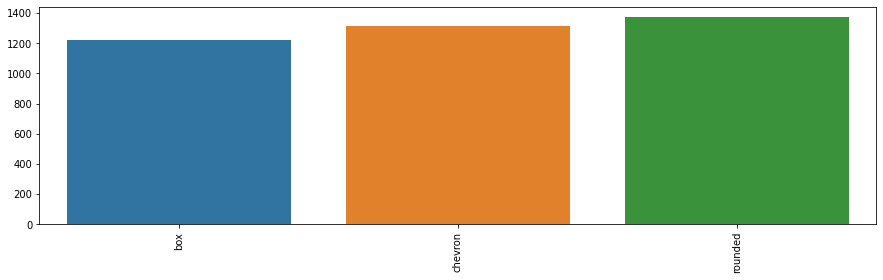

In [ ]:
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x=folds[:60],y=label[:60])
plt.xticks(rotation=90)
plt.show()

### **3.4.2 Validation dataset**

In [ ]:
folds=list(val_generator.class_indices.keys())

In [ ]:
x=list(val_generator.classes)

In [ ]:
label=[]
for i in range (0, num_classes):
    label.append(x.count(i))

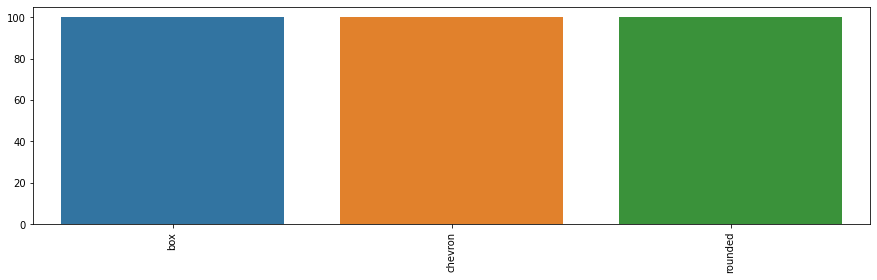

In [ ]:
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x=folds[:60],y=label[:60])
plt.xticks(rotation=90)
plt.show()

### **3.4.3 Testing dataset**

In [ ]:
folds=list(test_generator.class_indices.keys())

In [ ]:
x=list(test_generator.classes)

In [ ]:
label=[]
for i in range (0, num_classes):
    label.append(x.count(i))

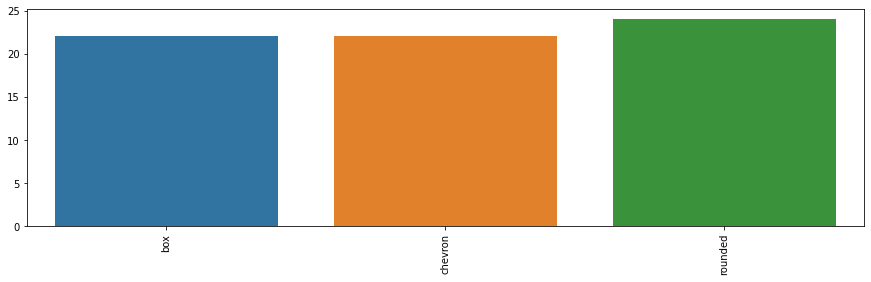

In [ ]:
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x=folds[0:10],y=label[0:10])
plt.xticks(rotation=90)
plt.show()

## **3.5 Examples of folding dataset**

### **3.5.1 Training dataset**

**Class 1 -Chevron fold**

In [ ]:
# image1 = np.array(Image.open('/content/drive/MyDrive/fold/TRAIN/chevron/26 (2).PNG'))
# plt.imshow(image1, cmap='gray')

**Class 2 - Box fold**

In [ ]:
# image1 = np.array(Image.open('/content/drive/MyDrive/fold/TRAIN/box/g1299.png'))
# plt.imshow(image1, cmap='gray')

**Class 3 - Rounded fold**

In [ ]:
# image3 = np.array(Image.open('/content/drive/MyDrive/fold/TRAIN/rounded/2 (6).png'))
# plt.imshow(image3, cmap='gray')

# **4. Data Augmentations and Normalization**

In [ ]:
image_size = 32 # 32

In [ ]:
import PIL.Image

In [ ]:
# Data transforms (normalization & data augmentation) # tt.RandomCrop(64, padding=4, padding_mode='reflect')
stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
randomrotate = 10 # 0.175 rad
train_tfms = tt.Compose([tt.Resize((image_size, image_size)),
                         tt.RandomCrop(image_size, padding=4, padding_mode='reflect'),
                         tt.Resize(image_size),
                         tt.CenterCrop(image_size), 
                         tt.RandomHorizontalFlip(),
                         tt.RandomVerticalFlip(), 
                         tt.Pad((2, 5, 0, 5)),
                         #tt.RandomRotation(randomrotate),
                         tt.RandomAffine(0, translate=(0.4, 0.5)),
                         tt.RandomRotation(randomrotate, resample=PIL.Image.NEAREST, expand=False, center=(40, 80), fill=100), ##
                         #tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), ##
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.Resize((image_size, image_size)), tt.ToTensor(), tt.Normalize(*stats)])

test_tfms = tt.Compose([tt.Resize((image_size, image_size)), tt.ToTensor(), tt.Normalize(*stats)])

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1201: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


In [ ]:
# PyTorch Training & Validation & Test Datasets
train_ds = ImageFolder(data_dir+'/TRAIN', train_tfms)
valid_ds = ImageFolder(data_dir+'/VAL', valid_tfms)
test_ds = ImageFolder(data_dir+'/TEST', test_tfms)

# **5. Data Loader**

Next, we can create data loaders for retrieving images in batches. I will use a relatively large batch size of 400 or 256 to utlize a larger portion of the GPU RAM. The, I try reducing the batch size & restarting the kernel if I face an "out of memory" error.

In [ ]:
batch_size = 400 # 256

In [ ]:
# PyTorch Training & Validation & Test Data Loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Let's take a look at some sample images from the training dataloader. To display the images, I need to denormalize the pixels values to bring them back into the range (0,1).

In [ ]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

In [ ]:
# show_batch(train_dl)

In [ ]:
# show_batch(valid_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


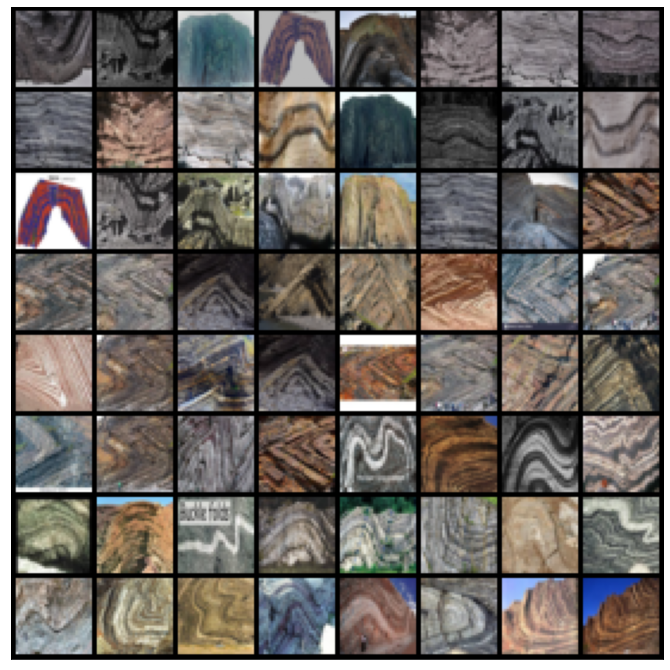

In [ ]:
show_batch(test_dl)

The colors seem out of place because of the normalization. Note that normalization is also applied during inference. When looking closely, I can spot the cropping and reflection padding in some of the images. Horizontal flip is a bit difficult to detect from visual inspection.

In [ ]:
# !pip install jovian --upgrade -q
# import jovian
# jovian.set_project('fold-deep-learning-resnet152-projec-all')
# jovian.set_colab_id('13ioHD681lSaJm8KvyoRVMsHVjhoJtsRt')
# jovian.commit(project=project_name, environment=None)

# **6. Modelling**

## **6.1 Utilizing GPU**

To seamlessly use a GPU, if one is available, I define a couple of helper functions (`get_default_device` & `to_device`) besides a helper class `DeviceDataLoader` to move my model & data to the GPU as required. 

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where this notebook is being run on the cloud, the default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`)

In [ ]:
device = get_default_device()
device

device(type='cuda')

I wrap my training and validation data loaders using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available).

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

# **7. Model Training**

# **7.1 Modifying a Pretrained Model (ResNet34)**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
from torchvision import models

class FoldsModel(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=False):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet101(pretrained=False)
        # Replace last layer
        self.network.fc = nn.Sequential(nn.Linear(self.network.fc.in_features, num_classes))
            
    def forward(self, xb):
        return self.network(xb)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
device = get_default_device()
device

device(type='cuda')

## **7.3.2 Finetuning the Pretrained Model**

In [ ]:
model = FoldsModel(len(train_ds.classes), pretrained=False)
to_device(model, device);

Before I begin training, I evaluate the instantiated model in order to see how it performs on the validation set with the initial set of parameters.

In [ ]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.3333333432674408, 'val_loss': 91.12507629394531}]

In [ ]:
epochs = 80 #80gd got70, 
max_lr = 0.003  #a 0.01gd got70, 0.001 got 76, 0.0001 got 71, 0.003 got 77, 0.004 got 76, 0.002 got 75, 0.006 got 73, 0.002 got 76, 0.0009 got 73
grad_clip = 0.1  # 0.1 
weight_decay = 1e-4  # 1e-4gd ot70, 76 
opt_func = torch.optim.Adam  # torch.optim.SGD

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch [0],last_lr: 0.00013, train_loss: 1.1769, val_loss: 1.1023, val_acc: 0.3167



Epoch [1],last_lr: 0.00016, train_loss: 1.1438, val_loss: 1.1073, val_acc: 0.3200



Epoch [2],last_lr: 0.00022, train_loss: 1.1319, val_loss: 1.1053, val_acc: 0.3333



Epoch [3],last_lr: 0.00031, train_loss: 1.1280, val_loss: 1.1244, val_acc: 0.3000



Epoch [4],last_lr: 0.00041, train_loss: 1.1286, val_loss: 1.1619, val_acc: 0.3400



Epoch [5],last_lr: 0.00053, train_loss: 1.1626, val_loss: 1.1383, val_acc: 0.3200



Epoch [6],last_lr: 0.00067, train_loss: 1.1786, val_loss: 1.1376, val_acc: 0.3333



Epoch [7],last_lr: 0.00083, train_loss: 1.1351, val_loss: 1.1638, val_acc: 0.3000



Epoch [8],last_lr: 0.00100, train_loss: 1.1411, val_loss: 1.1201, val_acc: 0.3367



Epoch [9],last_lr: 0.00118, train_loss: 1.1233, val_loss: 1.1245, val_acc: 0.3267



Epoch [10],last_lr: 0.00136, train_loss: 1.1658, val_loss: 1.0916, val_acc: 0.3667



Epoch [11],last_lr: 0.00155, train_loss: 1.0997, val_loss: 1.1143, val_acc: 0.3667



Epoch [12],last_lr: 0.00174, train_loss: 1.1234, val_loss: 1.3412, val_acc: 0.3700



Epoch [13],last_lr: 0.00193, train_loss: 1.1639, val_loss: 1.2948, val_acc: 0.3333



Epoch [14],last_lr: 0.00210, train_loss: 1.1484, val_loss: 1.2054, val_acc: 0.3333



Epoch [15],last_lr: 0.00227, train_loss: 1.0363, val_loss: 1.1101, val_acc: 0.3333



Epoch [16],last_lr: 0.00243, train_loss: 1.0485, val_loss: 1.1797, val_acc: 0.3433



Epoch [17],last_lr: 0.00257, train_loss: 1.0320, val_loss: 1.5405, val_acc: 0.3333



Epoch [18],last_lr: 0.00270, train_loss: 0.9664, val_loss: 1.1270, val_acc: 0.3300



Epoch [19],last_lr: 0.00281, train_loss: 0.9489, val_loss: 1.1237, val_acc: 0.3400



Epoch [20],last_lr: 0.00289, train_loss: 0.9199, val_loss: 1.1620, val_acc: 0.3467



Epoch [21],last_lr: 0.00295, train_loss: 0.9029, val_loss: 1.1492, val_acc: 0.3633



Epoch [22],last_lr: 0.00299, train_loss: 0.8855, val_loss: 1.1770, val_acc: 0.3867



Epoch [23],last_lr: 0.00300, train_loss: 0.8802, val_loss: 1.2131, val_acc: 0.3667



Epoch [24],last_lr: 0.00300, train_loss: 0.8733, val_loss: 1.1477, val_acc: 0.3467



Epoch [25],last_lr: 0.00299, train_loss: 0.8730, val_loss: 1.1731, val_acc: 0.3433



Epoch [26],last_lr: 0.00298, train_loss: 0.8550, val_loss: 1.1683, val_acc: 0.3500



Epoch [27],last_lr: 0.00296, train_loss: 0.8410, val_loss: 1.1615, val_acc: 0.3500



Epoch [28],last_lr: 0.00294, train_loss: 0.8341, val_loss: 1.1976, val_acc: 0.3500



Epoch [29],last_lr: 0.00292, train_loss: 0.8371, val_loss: 1.2182, val_acc: 0.3567



Epoch [30],last_lr: 0.00289, train_loss: 0.8188, val_loss: 1.2220, val_acc: 0.3567



Epoch [31],last_lr: 0.00285, train_loss: 0.8069, val_loss: 1.2243, val_acc: 0.3600



Epoch [32],last_lr: 0.00281, train_loss: 0.7958, val_loss: 1.4619, val_acc: 0.3600



Epoch [33],last_lr: 0.00277, train_loss: 0.7983, val_loss: 1.2505, val_acc: 0.3500



Epoch [34],last_lr: 0.00272, train_loss: 0.7954, val_loss: 1.3645, val_acc: 0.3433



Epoch [35],last_lr: 0.00267, train_loss: 0.7747, val_loss: 1.2227, val_acc: 0.3467



Epoch [36],last_lr: 0.00262, train_loss: 0.7605, val_loss: 1.2618, val_acc: 0.3033



Epoch [37],last_lr: 0.00256, train_loss: 0.8071, val_loss: 1.2174, val_acc: 0.3600



Epoch [38],last_lr: 0.00250, train_loss: 0.7543, val_loss: 1.3351, val_acc: 0.3367



Epoch [39],last_lr: 0.00244, train_loss: 0.7760, val_loss: 1.1955, val_acc: 0.3133



Epoch [40],last_lr: 0.00237, train_loss: 0.7554, val_loss: 1.2607, val_acc: 0.3433



Epoch [41],last_lr: 0.00230, train_loss: 0.7379, val_loss: 1.2630, val_acc: 0.3333



Epoch [42],last_lr: 0.00223, train_loss: 0.7221, val_loss: 1.1962, val_acc: 0.3267



Epoch [43],last_lr: 0.00215, train_loss: 0.7207, val_loss: 1.2878, val_acc: 0.3467



Epoch [44],last_lr: 0.00207, train_loss: 0.7198, val_loss: 1.3065, val_acc: 0.3567



Epoch [45],last_lr: 0.00200, train_loss: 0.6948, val_loss: 1.2058, val_acc: 0.3600



Epoch [46],last_lr: 0.00192, train_loss: 0.7122, val_loss: 1.1737, val_acc: 0.3633



Epoch [47],last_lr: 0.00183, train_loss: 0.6940, val_loss: 1.2714, val_acc: 0.3567



Epoch [48],last_lr: 0.00175, train_loss: 0.6796, val_loss: 1.2205, val_acc: 0.3800



Epoch [49],last_lr: 0.00167, train_loss: 0.6816, val_loss: 1.2219, val_acc: 0.3500



Epoch [50],last_lr: 0.00158, train_loss: 0.6791, val_loss: 1.1685, val_acc: 0.3767



Epoch [51],last_lr: 0.00150, train_loss: 0.6888, val_loss: 1.2424, val_acc: 0.3567



Epoch [52],last_lr: 0.00142, train_loss: 0.6786, val_loss: 1.2260, val_acc: 0.3767



Epoch [53],last_lr: 0.00133, train_loss: 0.6726, val_loss: 1.2928, val_acc: 0.3500



Epoch [54],last_lr: 0.00125, train_loss: 0.6689, val_loss: 1.1796, val_acc: 0.3667



Epoch [55],last_lr: 0.00117, train_loss: 0.6555, val_loss: 1.1758, val_acc: 0.3967



Epoch [56],last_lr: 0.00108, train_loss: 0.6435, val_loss: 1.2972, val_acc: 0.3633



Epoch [57],last_lr: 0.00100, train_loss: 0.6411, val_loss: 1.3362, val_acc: 0.3667



Epoch [58],last_lr: 0.00093, train_loss: 0.6407, val_loss: 1.2072, val_acc: 0.3833



Epoch [59],last_lr: 0.00085, train_loss: 0.6390, val_loss: 1.2402, val_acc: 0.3933



Epoch [60],last_lr: 0.00077, train_loss: 0.6268, val_loss: 1.1931, val_acc: 0.3767



Epoch [61],last_lr: 0.00070, train_loss: 0.6076, val_loss: 1.2587, val_acc: 0.3800



Epoch [62],last_lr: 0.00063, train_loss: 0.6213, val_loss: 1.1820, val_acc: 0.3667



Epoch [63],last_lr: 0.00056, train_loss: 0.6100, val_loss: 1.2323, val_acc: 0.3767



Epoch [64],last_lr: 0.00050, train_loss: 0.6088, val_loss: 1.1968, val_acc: 0.3833



Epoch [65],last_lr: 0.00044, train_loss: 0.6208, val_loss: 1.2298, val_acc: 0.3933



Epoch [66],last_lr: 0.00038, train_loss: 0.5997, val_loss: 1.2103, val_acc: 0.3800



Epoch [67],last_lr: 0.00033, train_loss: 0.6144, val_loss: 1.2797, val_acc: 0.3633



Epoch [68],last_lr: 0.00028, train_loss: 0.6010, val_loss: 1.2133, val_acc: 0.3900



Epoch [69],last_lr: 0.00023, train_loss: 0.6032, val_loss: 1.2193, val_acc: 0.3900



Epoch [70],last_lr: 0.00019, train_loss: 0.5948, val_loss: 1.2290, val_acc: 0.3800



Epoch [71],last_lr: 0.00015, train_loss: 0.5955, val_loss: 1.2146, val_acc: 0.3833



Epoch [72],last_lr: 0.00011, train_loss: 0.5846, val_loss: 1.2188, val_acc: 0.3767



Epoch [73],last_lr: 0.00008, train_loss: 0.5917, val_loss: 1.2245, val_acc: 0.3900



Epoch [74],last_lr: 0.00006, train_loss: 0.6039, val_loss: 1.2194, val_acc: 0.3833



Epoch [75],last_lr: 0.00004, train_loss: 0.5743, val_loss: 1.2176, val_acc: 0.3833



Epoch [76],last_lr: 0.00002, train_loss: 0.5802, val_loss: 1.2206, val_acc: 0.3733



Epoch [77],last_lr: 0.00001, train_loss: 0.5873, val_loss: 1.2212, val_acc: 0.3767



Epoch [78],last_lr: 0.00000, train_loss: 0.5896, val_loss: 1.2247, val_acc: 0.3900



Epoch [79],last_lr: 0.00000, train_loss: 0.5780, val_loss: 1.2261, val_acc: 0.3900
CPU times: user 3min 23s, sys: 2min 23s, total: 5min 46s
Wall time: 36min 11s


In [ ]:
from matplotlib import spines
from matplotlib import axes

In [ ]:
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'
# plt.style.use('dark_background')
# matplotlib.spines[axis].set_color(color) 
# matplotlib.spines["bottom"].set_color("red")
# matplotlib.spines["left"].set_color("orange")
ax.spines['bottom'].set_color('#dddddd')
ax.spines['top'].set_color('#dddddd') 
ax.spines['right'].set_color('red')
ax.spines['left'].set_color('red')
plt.rc_context({'axes.edgecolor':'orange', 'xtick.color':'red', 'ytick.color':'green', 'figure.facecolor':'white'})

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-bx')
    plt.xlabel('epoch', color='C0')
    plt.ylabel('accuracy', color='C0')
    plt.title('Accuracy vs. No. of epochs', color='C0');

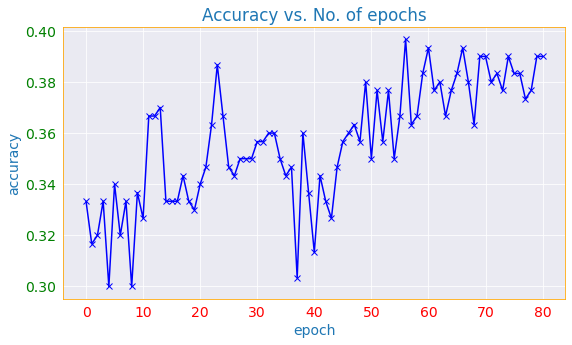

In [ ]:
plot_accuracies(history)

We also plot the Model Training and Validation Losses to investigate the training trend further down the improvement path.

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch', color='C0')
    plt.ylabel('loss', color='C0')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs', color='C0');

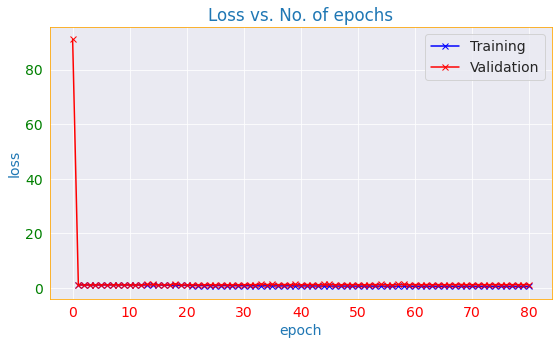

In [ ]:
plot_losses(history)

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs, 'C24-') # C11-
    plt.xlabel('Batch No.', color='C0')
    plt.ylabel('One Cycle Learning Rate Scheduler', color='C0')
    plt.title('One Cycle Learning Rate Scheduler vs. Batch No.', color='C0');

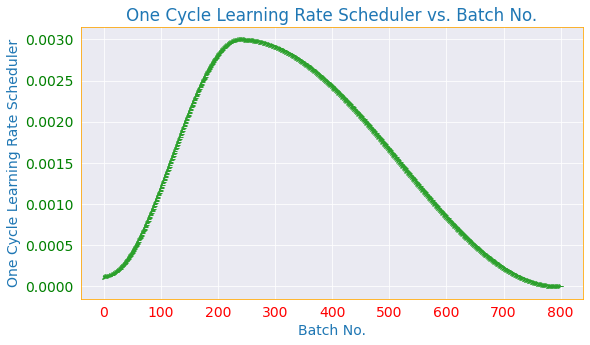

In [ ]:
plot_lrs(history)

In [ ]:
evaluate(model, test_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.3970588147640228, 'val_loss': 1.1604032516479492}

In [ ]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:', test_ds.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *imagenet_stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

In [ ]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

Label: chevron (1)


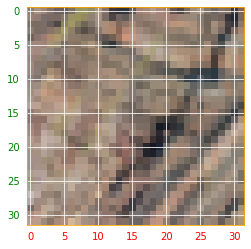

In [ ]:
show_image(*test_ds[38])

In [ ]:
def predict_image(img, model3):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Label: rounded , Predicted: rounded


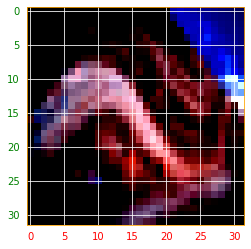

In [ ]:
# Image Test#3 (With Clamping)
img, label = test_ds[60]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', test_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: chevron (1)


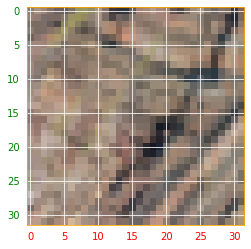

In [ ]:
show_image(*test_ds[38])

Label: chevron , Predicted: rounded


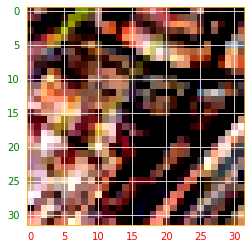

In [ ]:
# Image Test#2 (With Clamping)
img, label = test_ds[38]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', test_ds.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
# image2 = np.array(Image.open(r'C:\Users\r04ra18\Desktop\fold\fdata_aksh\TEST\rounded\images (61).jpg'))
# plt.imshow(image2, cmap='GnBu_r')

Label: chevron , Predicted: rounded


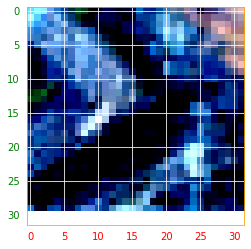

In [ ]:
# Image Test#2 (With Clamping)
img, label = test_ds[40]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', test_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: box , Predicted: box


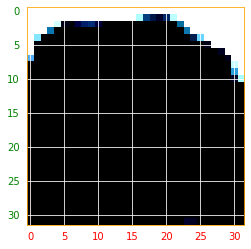

In [ ]:
# Image Test#3 (With Clamping)
img, label = test_ds[12]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', test_ds.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: box , Predicted: rounded


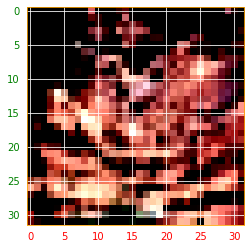

In [ ]:
# Image Test#4 (Withour Clamping)
# Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
img, label = test_ds[9]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_ds.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: box , Predicted: rounded


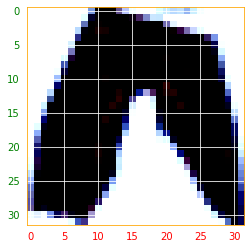

In [ ]:
# Image Test#5 (Withour Clamping)
# Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
img, label = test_ds[3]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_ds.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.38999998569488525, 'val_loss': 1.226103663444519}]

In [ ]:
history = [evaluate(model, test_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.3970588147640228, 'val_loss': 1.1604032516479492}]

In [ ]:
torch.save(model.state_dict(), 'fold_deep_learning_ResNet101_untrained_projec_all.pth')

In [ ]:
model.state_dict()

OrderedDict([('network.conv1.weight',
              tensor([[[[ 1.5404e-03,  1.3361e-02, -1.3302e-02,  ...,  2.1541e-02,
                         -2.2606e-02, -4.0326e-02],
                        [-1.1374e-02,  1.1691e-02, -1.2705e-02,  ...,  2.1873e-02,
                         -8.2174e-03, -2.3350e-02],
                        [-5.1718e-03, -1.2135e-02,  1.4138e-02,  ...,  7.6090e-04,
                         -4.7916e-02, -4.7861e-02],
                        ...,
                        [ 7.5118e-03,  1.6191e-03,  2.9672e-03,  ..., -2.1015e-02,
                          2.3694e-02, -3.4814e-03],
                        [ 1.8988e-02,  1.0648e-02,  6.1223e-03,  ...,  3.6689e-02,
                          1.2435e-02,  7.4380e-02],
                        [ 2.4408e-02,  3.1152e-02,  4.6560e-02,  ...,  3.7664e-02,
                          3.4801e-02,  4.3084e-02]],
              
                       [[-5.7790e-02, -2.9982e-02, -4.3880e-02,  ...,  1.3190e-02,
                        

In [ ]:
model_load = to_device(FoldsModel(3, 3), device)

In [ ]:
model_load.state_dict()

OrderedDict([('network.conv1.weight',
              tensor([[[[ 0.0147,  0.0580, -0.0099,  ...,  0.0290, -0.0197, -0.0319],
                        [-0.0227,  0.0276,  0.0236,  ..., -0.0186, -0.0165, -0.0343],
                        [-0.0375, -0.0123,  0.0294,  ..., -0.0070, -0.0015,  0.0188],
                        ...,
                        [ 0.0123,  0.0120, -0.0595,  ..., -0.0055,  0.0142,  0.0305],
                        [ 0.0047,  0.0349,  0.0504,  ..., -0.0289,  0.0011, -0.0086],
                        [-0.0020,  0.0132,  0.0395,  ..., -0.0017,  0.0210, -0.0357]],
              
                       [[-0.0351, -0.0076,  0.0130,  ..., -0.0103, -0.0192, -0.0140],
                        [ 0.0194,  0.0247,  0.0096,  ..., -0.0243, -0.0278, -0.0202],
                        [-0.0058, -0.0202, -0.0059,  ..., -0.0196, -0.0029, -0.0600],
                        ...,
                        [-0.0014, -0.0185, -0.0097,  ..., -0.0038,  0.0087,  0.0055],
                        [-0.

In [ ]:
model_load.load_state_dict(torch.load('fold_deep_learning_ResNet101_untrained_projec_all.pth'))

<All keys matched successfully>

Just as a sanity check, I also verify that this newly loaded model has the same loss and accuracy on the test set as before.

In [ ]:
evaluate(model_load, valid_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.38999998569488525, 'val_loss': 1.226103663444519}

In [ ]:
evaluate(model_load, test_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.3970588147640228, 'val_loss': 1.1604032516479492}

In [ ]:
data_loader = torch.utils.data.DataLoader(
     train_ds, batch_size=3)

In [ ]:
batch = next(iter(data_loader))
images, labels = batch

In [ ]:
images.shape

torch.Size([3, 3, 42, 34])

In [ ]:
labels.shape

torch.Size([3])

In [ ]:
preds = model(images)
preds

RuntimeError: ignored

In [ ]:
preds.shape

In [ ]:
preds

In [ ]:
preds.argmax(dim=1)

In [ ]:
labels

In [ ]:
preds.argmax(dim=1).eq(labels)

In [ ]:
preds.argmax(dim=1).eq(labels).sum()

In [ ]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [ ]:
get_num_correct(preds, labels)

In [ ]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

In [ ]:
with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(train_ds, batch_size=10000)
    train_preds = get_all_preds(model, prediction_loader)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
from collections import Counter

In [ ]:
cm = confusion_matrix(train_ds.targets, train_preds.argmax(dim=1))
print(type(cm))

In [ ]:
cm

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

# plt.cm.Reds
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
plt.figure(figsize=(4, 4))
plot_confusion_matrix(cm, train_ds.classes)

In [ ]:
with torch.no_grad():
    prediction_test_ld = torch.utils.data.DataLoader(test_ds, batch_size=10000)
    test_preds = get_all_preds(model, prediction_test_ld)

In [ ]:
cm_test = confusion_matrix(test_ds.targets, test_preds.argmax(dim=1))
print(type(cm_test))

In [ ]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm_test, test_ds.classes)

In [ ]:
with torch.no_grad():
    prediction_val_ld = torch.utils.data.DataLoader(valid_ds, batch_size=10000)
    valid_preds = get_all_preds(model, prediction_val_ld)

In [ ]:
cm_valid = confusion_matrix(valid_ds.targets, valid_preds.argmax(dim=1))
print(type(cm_valid))

In [ ]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm_valid, valid_ds.classes)